# Gaussian Mixture

Esta notebook realiza un análisis de clustering sobre un conjunto de datos de órdenes (ordenes_cluster.csv) utilizando técnicas de preprocesamiento, reducción de dimensionalidad y modelado. Los pasos principales son:

**Carga y Preparación de Datos:**

Se importa el dataset ordenes_cluster.csv y se excluyen columnas específicas (como order_id, user_id, y variables categóricas o redundantes) para crear un conjunto de datos limpio (X).

**Escalado de Variables:**

Se aplica un escalado estándar (StandardScaler) a las variables numéricas, preservando las categóricas (aux_has_discount, week_cos, week_sin, y otras) sin transformar.

**Reducción de Dimensionalidad:**

Se utiliza PCA (Principal Component Analysis) para reducir la dimensionalidad del conjunto de datos, conservando el 95% de la varianza, generando un nuevo conjunto de datos (X_reduced) con componentes principales.

**Muestreo:** 

Se toma una muestra aleatoria del 100% de los datos reducidos (X_reduced_sample) con una semilla fija para reproducibilidad.

**Clustering con GMM:**

Se entrena un modelo de Mezcla de Gaussianas (GMM) con diferentes números de componentes (10, 15, 20) y se selecciona el mejor modelo según el criterio BIC.

**Visualización:**

Se generan gráficos de barras para comparar las medias de las variables por clúster, excluyendo variables categóricas y relacionadas con la semana, utilizando la función bar_plots_N_var.

El objetivo es explorar patrones en los datos de órdenes mediante clustering, facilitando la identificación de grupos significativos basados en las características procesadas.

## Importacion de librerias

In [35]:
# --- Manejo de datos ---
import pandas as pd          # Estructuras de datos y manejo de DataFrames
import numpy as np           # Operaciones numéricas, arreglos, funciones vectorizadas
import math                  # Funciones matemáticas básicas (ceil, sqrt, etc.)

# --- Preprocesamiento ---
from sklearn.preprocessing import StandardScaler  # Estandarización (media 0, desv. estándar 1)

# --- Reducción de dimensionalidad ---
from sklearn.decomposition import PCA             # PCA para representar datos en componentes principales
from sklearn.manifold import TSNE                 # t-SNE para proyección no lineal en 2D

# --- Modelado y agrupamiento ---
from sklearn.cluster import KMeans                # Algoritmo clásico de clustering por centroide
from sklearn.mixture import GaussianMixture       # Modelo de mezcla gaussiana para clusters probabilísticos
from hdbscan import HDBSCAN                       # Algoritmo basado en densidad para clusters con ruido

# --- Evaluación de segmentación ---
from sklearn.metrics import silhouette_score      # Métrica para evaluar cohesión/separación de clusters

# --- Visualización ---
import seaborn as sns                             # Gráficos estadísticos estilizados
import matplotlib.pyplot as plt                   # Visualización básica (figuras, ejes, ajustes)


# --- Estilo gráfico global ---
sns.set_style("whitegrid")  # Fondo de gráficos con cuadrícula clara

plt.rcParams.update({
    'axes.titlesize': 16,       # Tamaño del título del gráfico
    'axes.labelsize': 14,       # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 12,      # Tamaño de los valores en el eje X
    'ytick.labelsize': 12,      # Tamaño de los valores en el eje Y
    'legend.fontsize': 12,      # Tamaño de la fuente en la leyenda
    'figure.titlesize': 18      # Tamaño del título principal si se usa plt.suptitle
})


In [36]:
Flag = False  # Cambia a False si quieres cargar etiquetas precomputadas


## Carga de datos

In [37]:
ordenes_cluster = pd.read_csv('tabla_para_clusterizacion.csv')
ordenes_cluster_df = ordenes_cluster.copy()
ordenes_cluster_df.columns

Index(['order_id', 'weekday', 'hour', 'vendor_id', 'user_id', 'total_amount',
       'has_discount', 'cant_prod_por_ped', 'cant_ordenes_vendor',
       'cat1_por_vendor', 'cat2_por_vendor', 'mean_euc_dist', 'max_euc_dist',
       'min_euc_dist', 'mean_frec_global', 'std_frec_global', 'cant_ord_user',
       'identical_order_count', 'precio_prom_prod', 'log_precio_prom_prod',
       'cant_level_one_unicos', 'aux_has_discount', 'A', 'B', 'C', 'D', 'E',
       'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'fin_de_semana_mañana',
       'fin_de_semana_mediodia', 'fin_de_semana_noche', 'fin_de_semana_tarde',
       'semana_mañana', 'semana_mediodia', 'semana_noche', 'semana_tarde',
       'week_sin', 'week_cos', 'log_sum_pairwise_cooc'],
      dtype='object')

## Preprocesamiento de datos


Se define el conjunto de variables a excluir (vars_a_excluir) para filtrar aquellas columnas que no aportan valor directo al proceso de clusterización, como identificadores (order_id, user_id, vendor_id), variables categóricas tipo dummy (cat_cols_s, sem_cols), métricas derivadas redundantes, o variables textuales no numéricas. A partir de esta selección, se construye el DataFrame X que contiene únicamente las variables relevantes para modelado.

In [38]:
# Definir columnas categóricas y a excluir
cat_cols = list('ABCDEFGHIJKLMN')
cat_cols_s = [col for col in ordenes_cluster_df.columns if col.endswith('_s')]
sem_cols = [col for col in ordenes_cluster_df.columns if 'semana' in col.lower()]
vars_a_excluir = ['order_id', 'user_id', 'vendor_id', 'weekday', 'has_discount', 'pct_por_hora', 'hour', 
                  'cant_ord_user', 'pct_por_dia', 'precio_prom_prod', 'identical_order_count'] + cat_cols_s + sem_cols
                 # + cat_cols \
                  #    + cat_cols_s \
                   #     + sem_cols

# Crear X (dataset original sin vars_a_excluir)
X = ordenes_cluster_df.drop(columns=[col for col in vars_a_excluir if col in ordenes_cluster_df.columns]).copy()

### Escalado de variables

Se aplica la estandarización Z-score con StandardScaler sobre todas las columnas de X, excepto aquellas definidas en exclude_cols, que incluyen variables binarias (aux_has_discount), componentes temporales cíclicos (week_sin, week_cos) y dummies categóricas (cat_cols). Estas variables excluidas se reinsertan en el DataFrame estandarizado X_scaled

In [39]:
exclude_cols = ['aux_has_discount','week_cos','week_sin'] + cat_cols

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)
X_scaled.loc[:, exclude_cols] = X[exclude_cols]

### Reduccion de dimensionalidad

Este bloque aplica reducción de dimensionalidad utilizando Análisis de Componentes Principales (PCA), conservando automáticamente suficientes componentes para retener el 95% de la varianza explicada del dataset escalado X_scaled. Se transforma la matriz original en X_reduced_array y luego se encapsula en un DataFrame con nombres de columnas generados dinámicamente (PC1, PC2, ..., PCn), manteniendo el índice original de X. Esta transformación permite simplificar el espacio de representación manteniendo la mayor cantidad de información posible para visualización o modelado posterior, especialmente útil para algoritmos como Gaussian Mixture o t-SNE.

In [40]:
pca = PCA(n_components=0.95)  # Conserva 95% de la varianza
X_reduced_array = pca.fit_transform(X_scaled)
pc_names = [f'PC{i+1}' for i in range(X_reduced_array.shape[1])]
X_reduced = pd.DataFrame(
    X_reduced_array,
    columns=pc_names,
    index=X.index
)

X_reduced.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'], dtype='object')

### Muestreo de datos

Se realiza un muestreo aleatorio sobre el conjunto reducido de componentes principales (X_reduced), manteniendo el 100% de las observaciones (frac=1). Esto permite reorganizar aleatoriamente los datos como paso previo a etapas de modelado o visualización, eliminando cualquier sesgo asociado al orden original de los registros. Aunque en este caso se trabaja con todo el universo disponible, la estructura está preparada para ajustar dinámicamente el porcentaje de datos a utilizar si se desea realizar pruebas más ligeras o ejecutar algoritmos sobre subconjuntos controlados.

In [41]:
X_reduced_sample = X_reduced.sample(frac=1, random_state=42).copy()

## Clusterizacion mediante Gaussian Mixture

Este bloque implementa la segmentación de órdenes utilizando el modelo de Gaussian Mixture con 5 componentes, conservando las etiquetas generadas en el DataFrame X_reduced_sample. Se utiliza init_params='kmeans' para iniciar los centroides desde K-Means, buscando mayor estabilidad en la convergencia del algoritmo. Las variables HDBSCAN_cluster y GMM_cluster se excluyen si están presentes para evitar conflictos al entrenar.

Si Flag está activo, se entrena el modelo y se generan las etiquetas probabilísticas (fit_predict) que se guardan en un archivo CSV. También se imprime la distribución relativa por cluster con cuatro decimales. En caso contrario, se carga directamente el archivo de etiquetas previamente generado, asegurando reproducibilidad en ejecuciones posteriores.

In [42]:
if Flag:
    # Entrenar el modelo final con el mejor n_components
    clusterer = GaussianMixture(
        n_components=5,
        covariance_type='full',
        init_params='kmeans',
        n_init=2,
        random_state=42,
        max_iter=200
    )
    labels = clusterer.fit_predict(X_reduced_sample.drop(columns=['HDBSCAN_cluster', 'GMM_cluster'], errors='ignore'))
    labels_df = pd.DataFrame(labels, columns=['GMM_cluster'])
    print(labels_df['GMM_cluster'].value_counts(normalize=True).sort_index().round(4))
    X_reduced_sample['GMM_cluster'] = labels_df['GMM_cluster'].values
    labels_df.to_csv('GMM_resultados.csv', index=False)
else:
    labels_df = pd.read_csv('GMM_resultados.csv')
    X_reduced_sample['GMM_cluster'] = labels_df['GMM_cluster'].values

### Silhouette Score

Este bloque evalúa la calidad de los clusters generados por el modelo de Gaussian Mixture, calculando el Silhouette Score sobre una muestra representativa del 10 % del universo reducido (X_reduced_sample).

In [43]:
# Preparar datos
X = X_reduced_sample.drop(columns=['HDBSCAN_cluster', 'GMM_cluster'], errors='ignore')
labels = X_reduced_sample['GMM_cluster'].values

# Calcular tamaño de muestra (10%)
sample_size = int(0.1 * X.shape[0])

# Silhouette Score con 10% de la muestra
sil_score = silhouette_score(
    X, 
    labels, 
    sample_size=sample_size, 
    random_state=42
)

print(f"Silhouette Score (10% muestra): {sil_score:.4f}")

Silhouette Score (10% muestra): 0.1497


In [44]:
X_reduced_sample['GMM_cluster'] = labels_df['GMM_cluster'].values

# Se asignan las etiquetas de cluster generadas por el modelo Gaussian Mixture (labels_df['GMM_cluster']) al DataFrame de trabajo X_reduced_sample, 
# almacenándolas en la nueva columna 'GMM_cluster'.

## Visualizacion
### TSNE

Este bloque genera una visualización bidimensional de los clústeres formados por el modelo de Gaussian Mixture (o HDBSCAN si GMM no está disponible), utilizando la técnica de t-SNE sobre un submuestreo del 20 % del conjunto de componentes principales (X_reduced_sample). El procedimiento sigue estos pasos:

Esta visualización es útil para explorar la estructura de los clústeres en un espacio no lineal, permitiendo observar posibles solapamientos o separaciones claras entre grupos. 

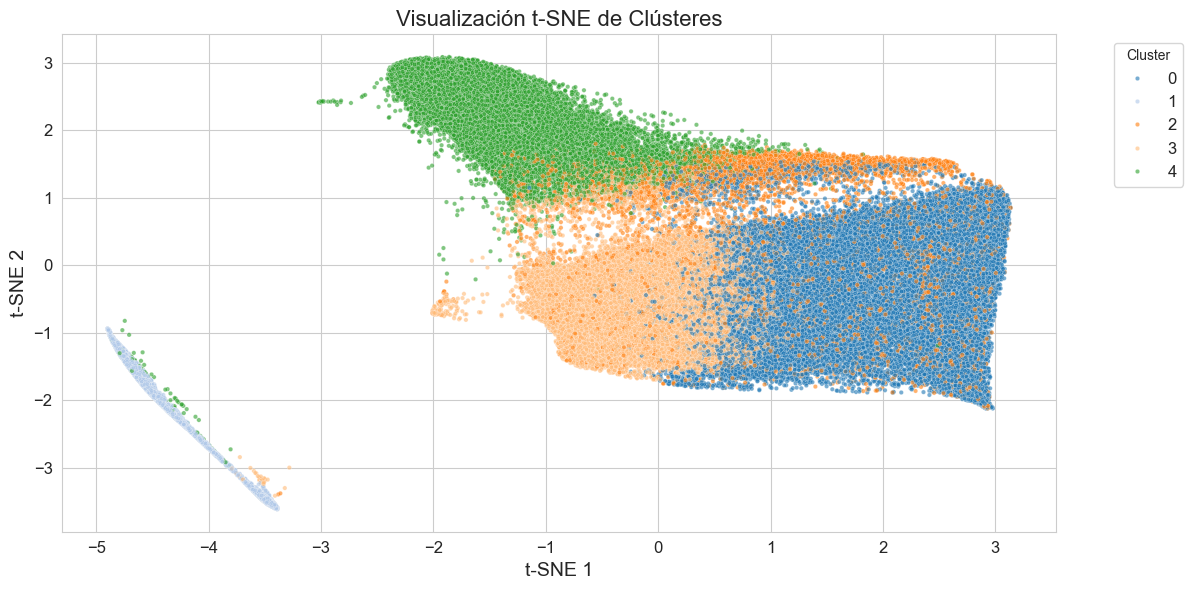

In [45]:
if Flag: 
   # Submuestreo
    sample_frac = .2 
    X_tsne_input = X_reduced_sample.sample(frac=sample_frac, random_state=42).copy()
    print(f"Tamaño de la muestra para t-SNE: {X_tsne_input.shape[0]} puntos")

    # Preparar datos para t-SNE (excluir columnas de clústeres)
    X_tsne_data = X_tsne_input.drop(columns=['HDBSCAN_cluster', 'GMM_cluster'], errors='ignore')
    labels = X_tsne_input.get('GMM_cluster', X_tsne_input.get('HDBSCAN_cluster'))

    # Reducir con t-SNE a 2 dimensiones
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        n_iter=250,
        random_state=42,
        n_jobs=-1
    )
    embedding = tsne.fit_transform(X_tsne_data)

    # Crear DataFrame con los resultados de t-SNE
    tsne_df = pd.DataFrame(embedding, columns=['TSNE1', 'TSNE2'], index=X_tsne_input.index)
    tsne_df['Cluster'] = labels.values
    tsne_df.to_csv('GMM_tsne_results.csv', index=False)

else:
    # Cargar etiquetas precomputadas
    tsne_df = pd.read_csv('GMM_tsne_results.csv')

# Graficar
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='Cluster',
    palette='tab20',
    data=tsne_df,
    legend='full',
    s=10,
    alpha=0.6
)
plt.title('Visualización t-SNE de Clústeres')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Caracterizacion

Este bloque permite reconstruir el contexto original de las observaciones para caracterizar los clústeres encontrados por el modelo GMM. Se parte del conjunto de datos limpio y sin columnas irrelevantes o derivadas (como identificadores, componentes principales y codificaciones auxiliares), y se escalan las variables numéricas mediante transformación estándar, asegurando que todas contribuyan en igualdad de condiciones a los análisis posteriores.

Luego se reintegran esas variables originales al subconjunto muestreado (X_reduced_sample), permitiendo asociar cada observación con su etiqueta de cluster y sus atributos transaccionales y de producto en estado estandarizado. Esto genera una vista coherente (df_sample_scaled) que preserva tanto la segmentación como las métricas originales para interpretar el perfil de cada grupo con consistencia técnica y comparabilidad.

In [46]:
vars_a_excluir = ['GMM_cluster', 'order_id', 'user_id', 'vendor_id', 'weekday', 'has_discount', 
                  'cant_ord_user', 'identical_order_count', 'pct_por_dia', 'pct_por_hora', 
                  'log_precio_prom_prod'] + \
                 [col for col in X_reduced_sample.columns if col.startswith('PC')] + \
                 [col for col in ordenes_cluster_df.columns if col.endswith('_s')] \
                  #  + cat_cols

# Filtrar vars_a_excluir para que solo incluya columnas presentes
vars_a_excluir = [col for col in vars_a_excluir if col in ordenes_cluster_df.columns or col in X_reduced_sample.columns]

# Escalar variables usando el dataset original
scaler = StandardScaler()
X_original = ordenes_cluster_df.drop(columns=[col for col in vars_a_excluir if col in ordenes_cluster_df.columns])
scaler.fit(X_original)

# Transformar el dataset original y la muestra
X_scaled = scaler.transform(X_original)
X_reduced_sample_original = X_reduced_sample.merge(
    ordenes_cluster_df[X_original.columns], 
    left_index=True, 
    right_index=True
)  
# Combinar X_reduced_sample con las columnas originales
X_reduced_sample_scaled = scaler.transform(X_reduced_sample_original[X_original.columns])

# Crear DataFrames escalados
df_scaled = pd.DataFrame(X_scaled, columns=X_original.columns, index=X_original.index)
df_sample_scaled = pd.DataFrame(
    X_reduced_sample_scaled,
    columns=X_original.columns,
    index=X_reduced_sample_original.index
)
df_sample_scaled['GMM_cluster'] = X_reduced_sample['GMM_cluster']

Este bloque permite identificar, caracterizar y contrastar los clústeres generados por el modelo GMM tomando como referencia tanto las variables estandarizadas como sus magnitudes originales.

Primero se calculan las medias globales y por clúster sobre el espacio escalado (df_sample_scaled), lo que permite medir cuán distante está cada grupo del comportamiento promedio. A partir de esas diferencias (diff), se seleccionan las N variables más distintivas para cada clúster—en este caso, las 6 de mayor valor z-score positivo por grupo (top_vars_z), es decir, aquellas que destacan por sobre la media general.

Luego, el análisis se replica sobre las variables en su escala original (medias_orig vs medias_global_orig), proporcionando una lectura más tangible de las diferencias entre clústeres en términos reales (euros, cantidades, proporciones, etc.). Esto permite vincular directamente los patrones descubiertos con decisiones comerciales o logísticas. Finalmente, se registra el tamaño total de la muestra (tot_elem), útil para ponderar los resultados o calcular proporciones.

In [47]:
# Calcular medias globales y por clúster (solo en la muestra)
media_global = df_scaled.mean()
medias = df_sample_scaled.groupby('GMM_cluster').mean()
diff = medias - media_global

# Definir las N variables más relevantes por clúster
N = 6
top_vars_z = {cl: diff.loc[cl].sort_values(ascending=False).head(N).index.tolist() for cl in diff.index}

# Calcular medias en la escala original
vars_orig = X_original.columns
medias_global_orig = X_original.mean()
medias_orig = X_reduced_sample_original.groupby('GMM_cluster')[vars_orig].mean()
diff_orig = medias_orig - medias_global_orig

# Calcular el total de elementos en la muestra
tot_elem = X_reduced_sample.shape[0]

In [48]:
# Función para calcular el grid de gráficos
def calcular_grid(n_graficos):
    ncols = math.ceil(math.sqrt(n_graficos))
    nrows = math.ceil(n_graficos / ncols)
    return nrows, ncols

nrows, ncols = calcular_grid(N)

Este bloque genera una visualización comparativa de los clústeres obtenidos con Gaussian Mixture, destacando las variables que más los diferencian respecto de la media global.


Cluster 0, 177321 elementos (0.36 del total)


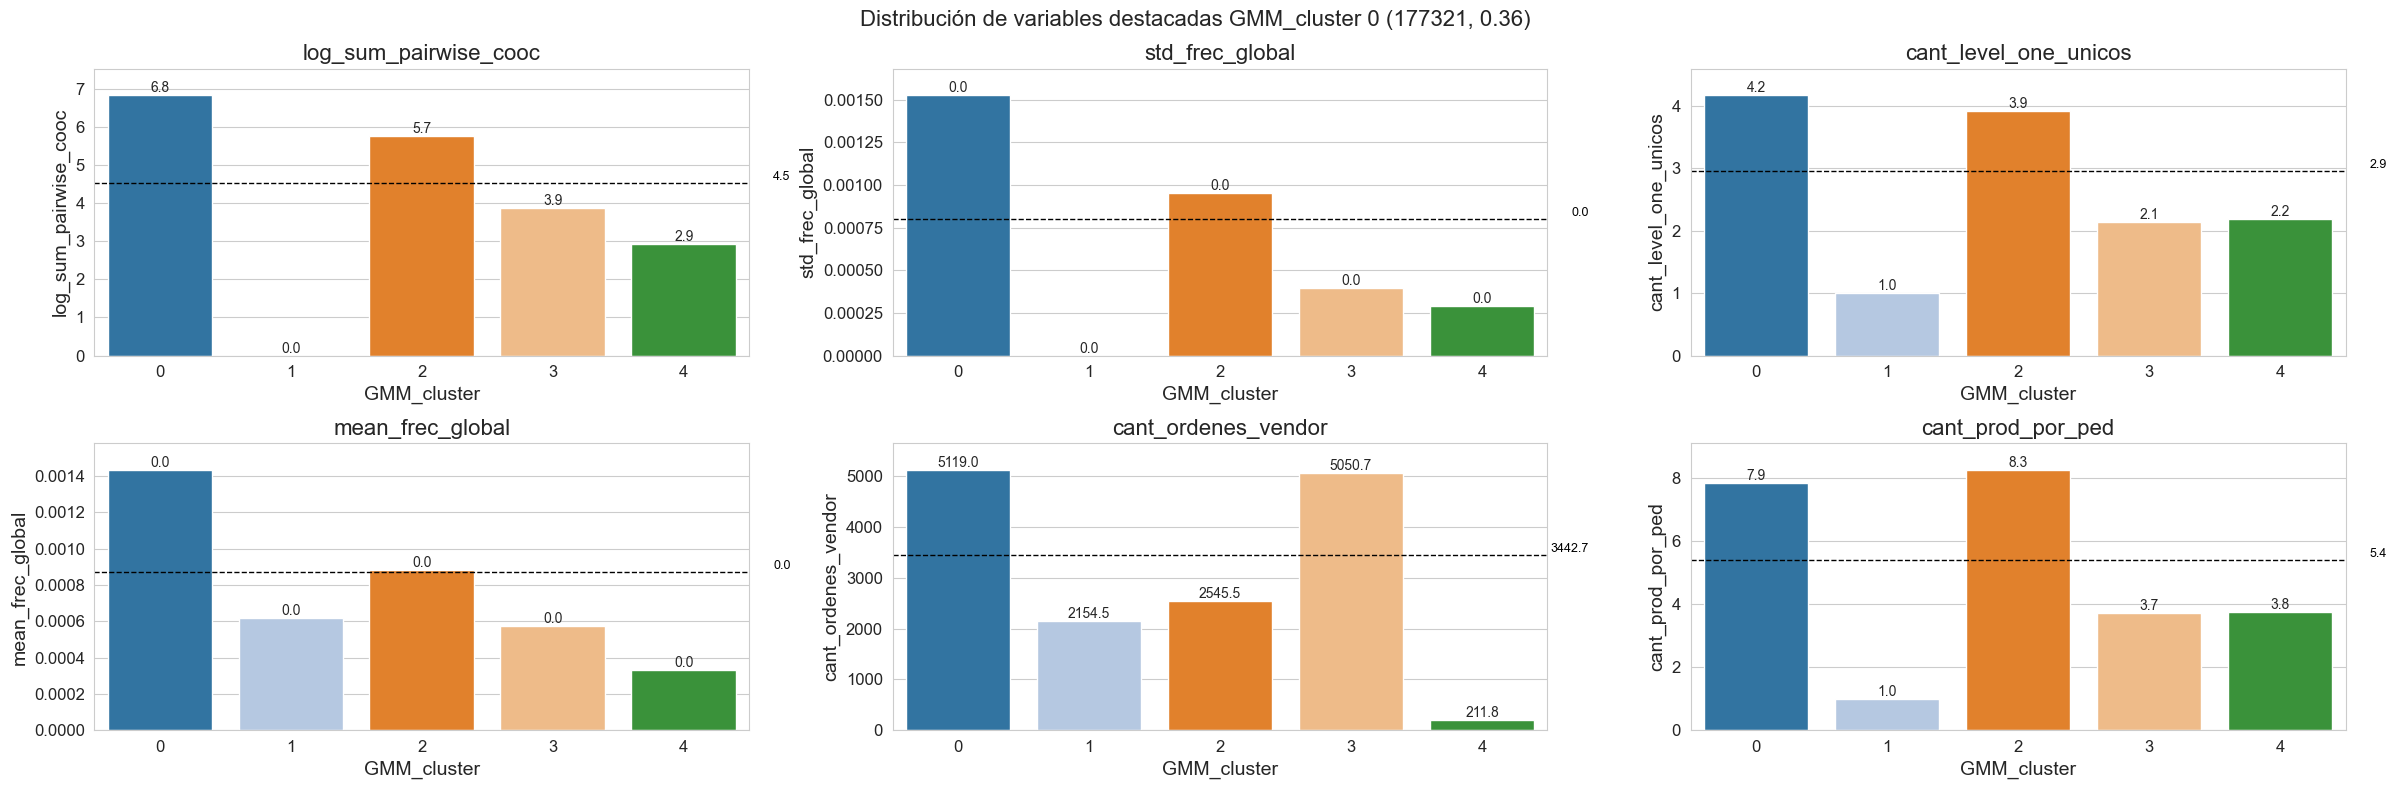


Cluster 1, 53580 elementos (0.11 del total)


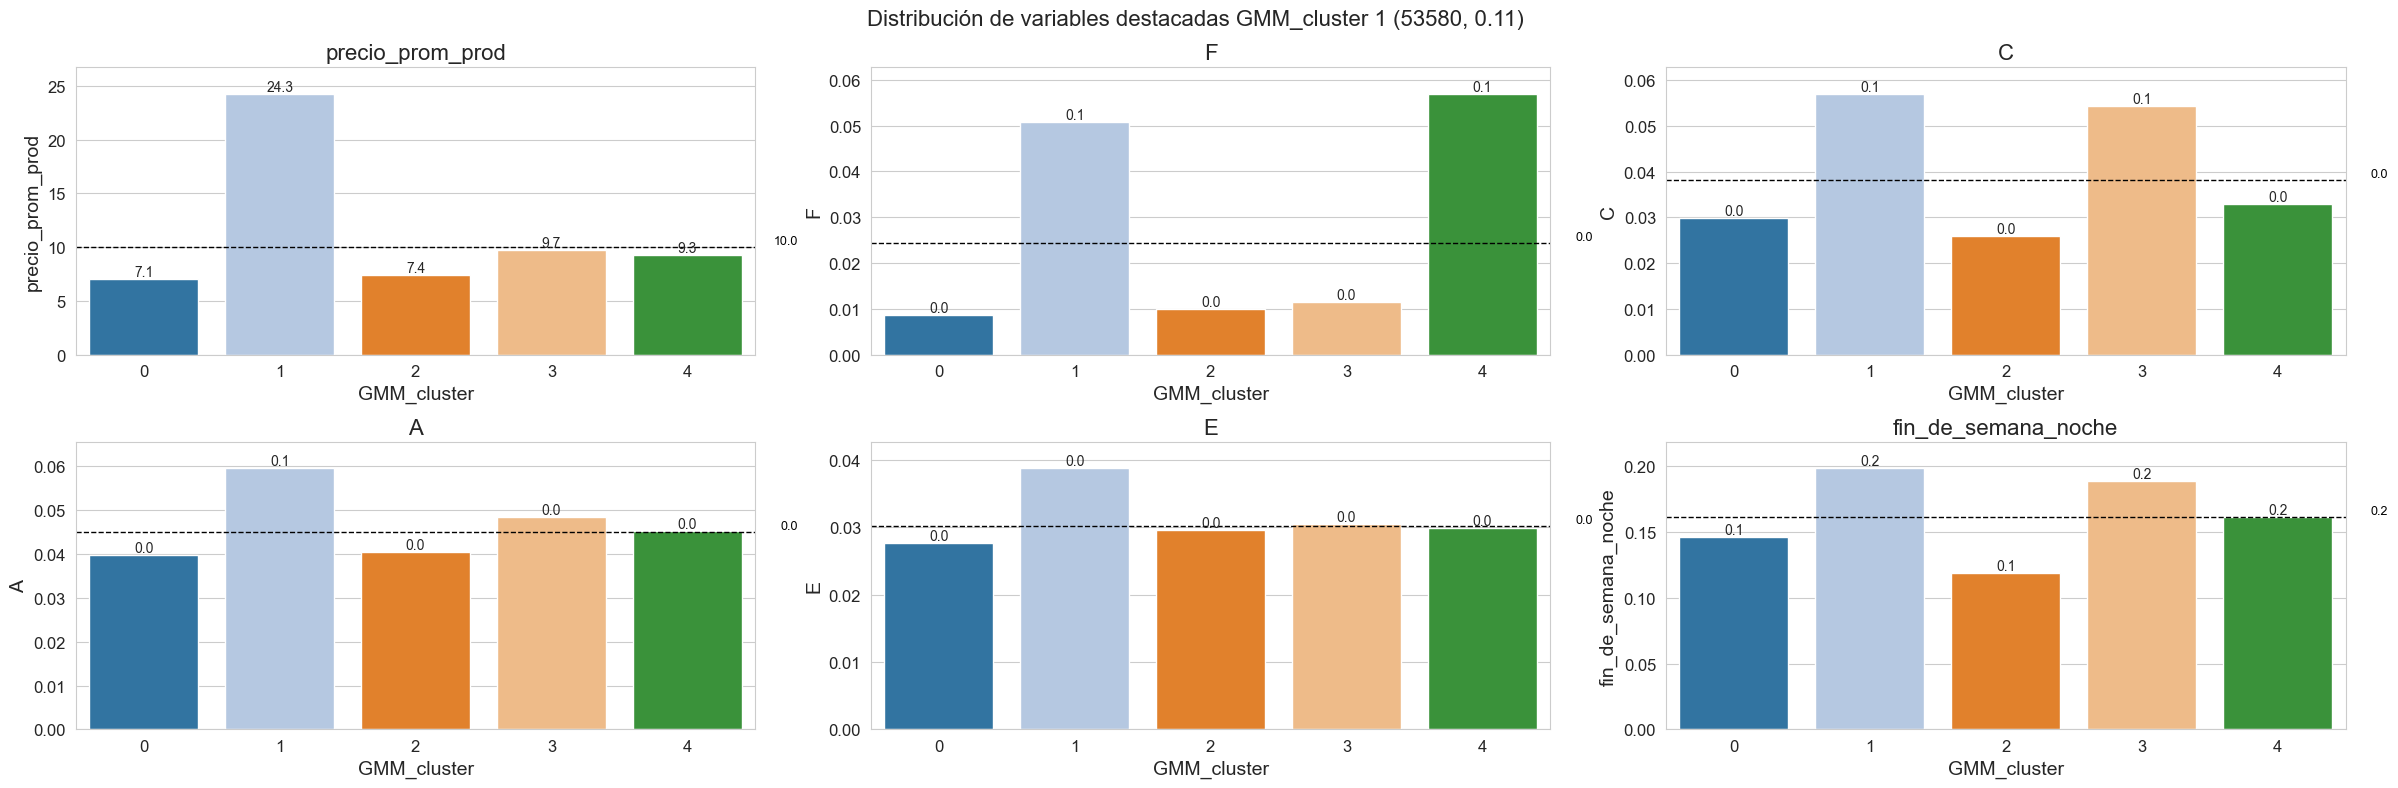


Cluster 2, 51858 elementos (0.11 del total)


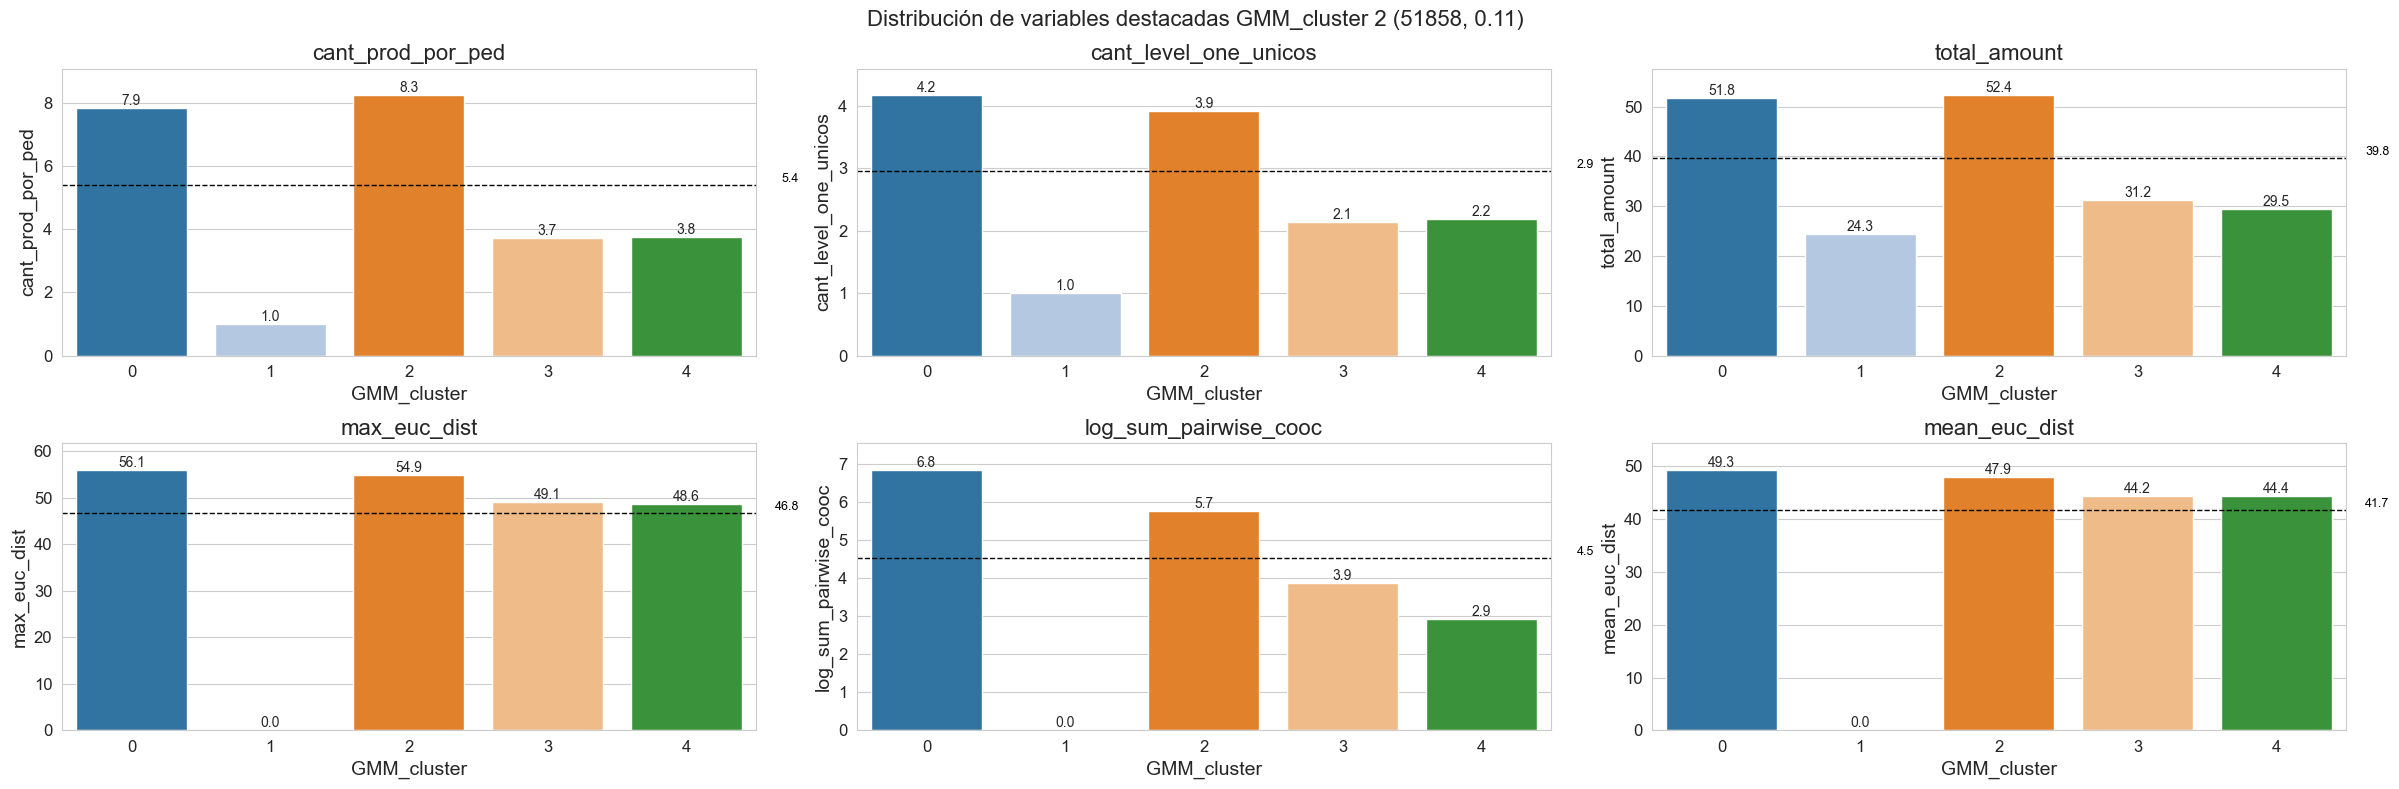


Cluster 3, 101336 elementos (0.21 del total)


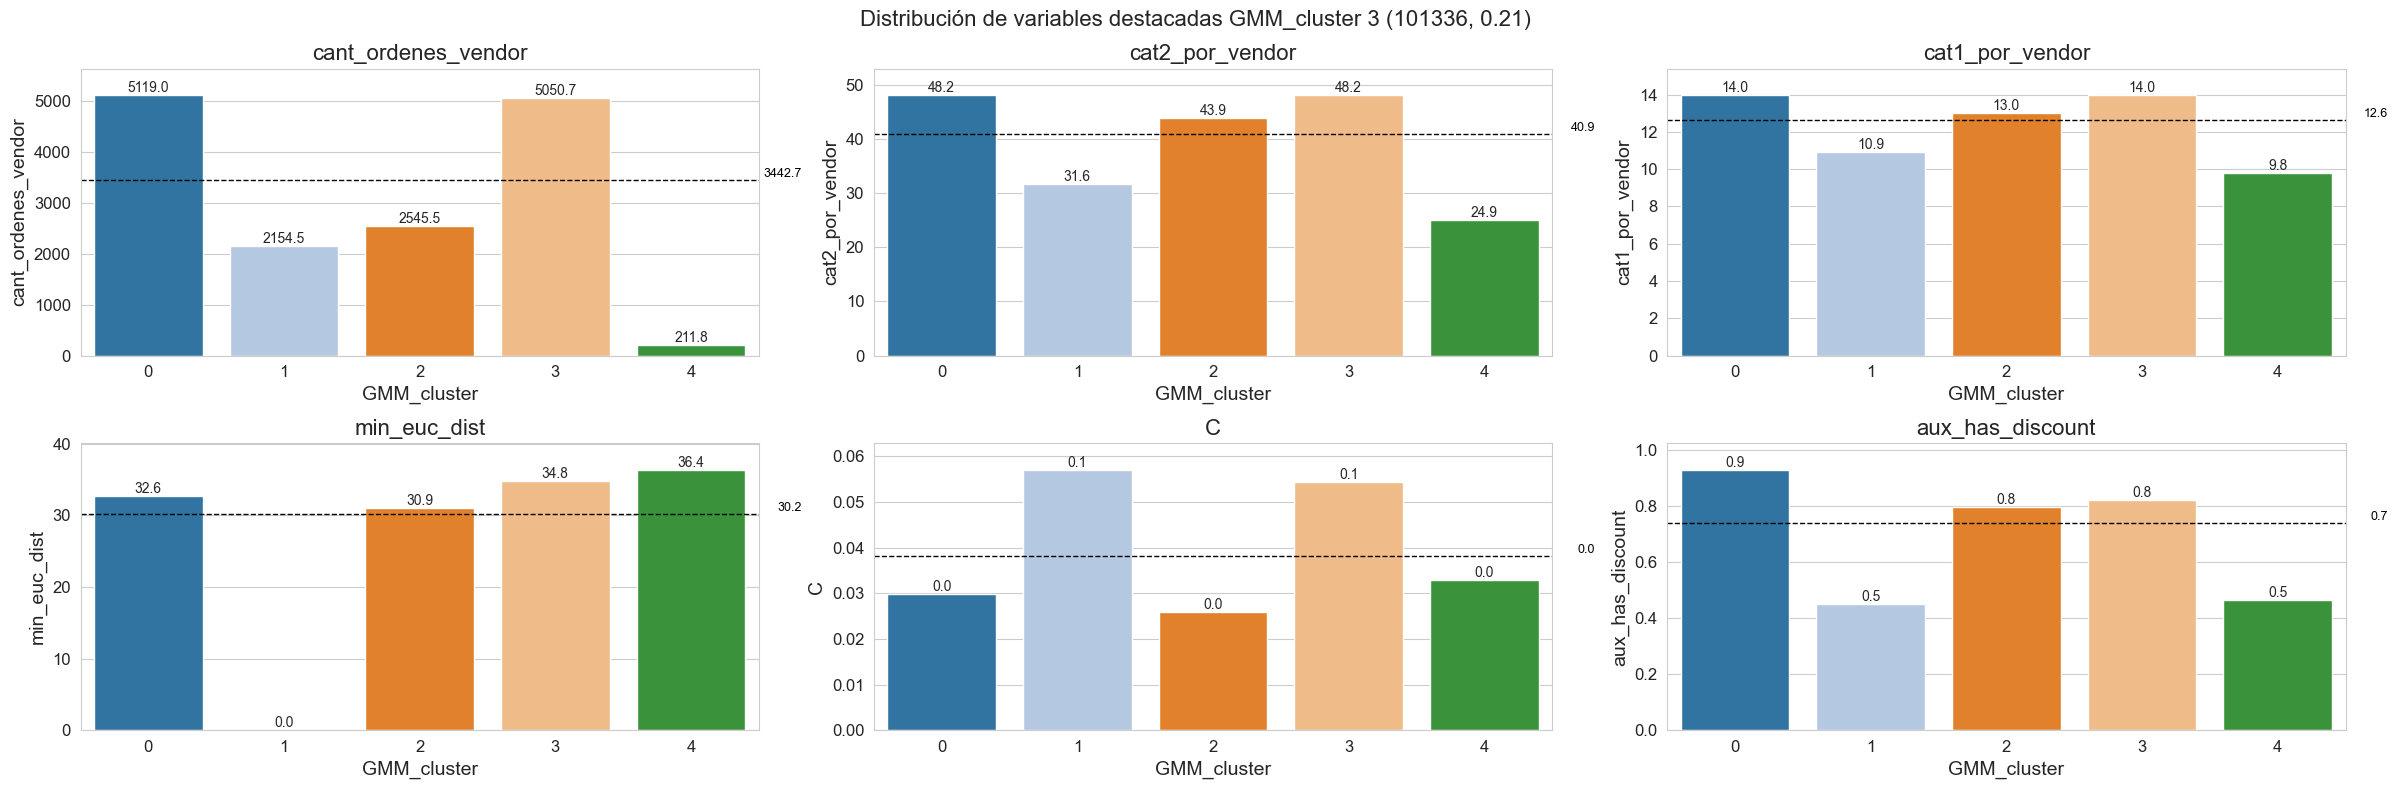


Cluster 4, 106676 elementos (0.22 del total)


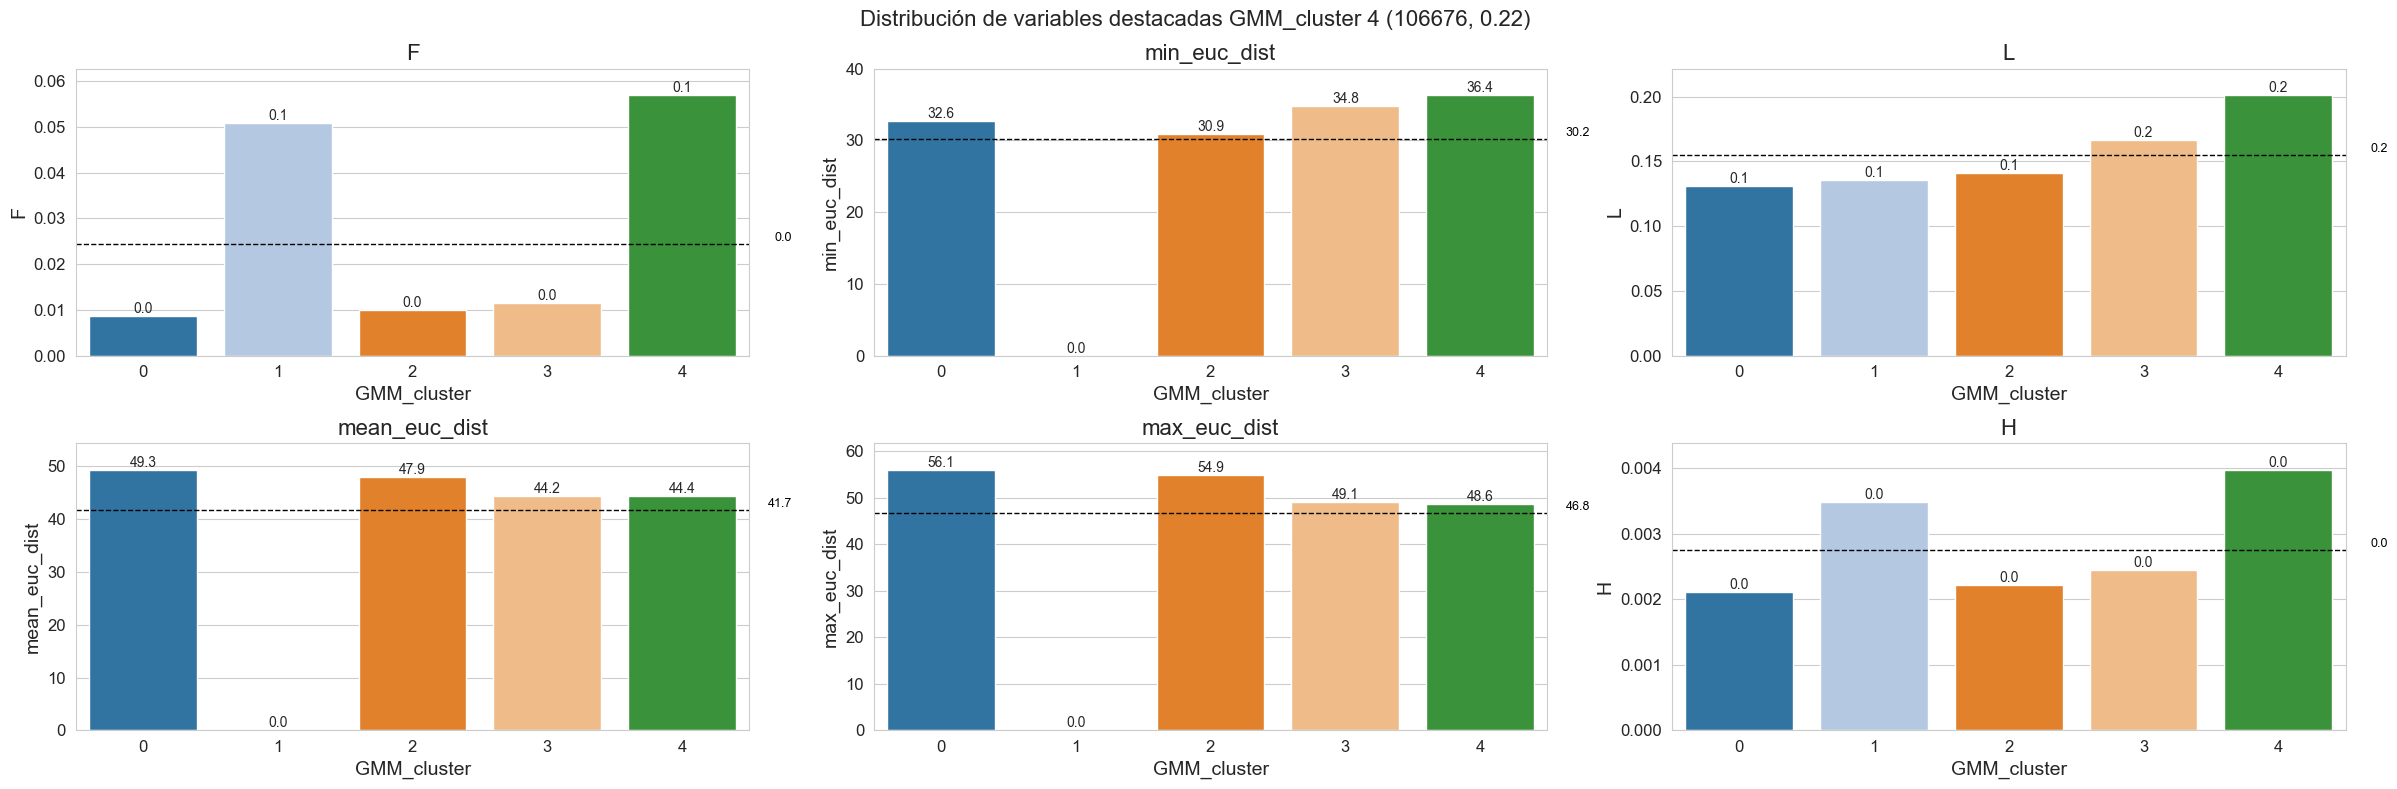

In [49]:
# Generar gráficos por clúster
for cl, vars_list in top_vars_z.items():
    n_elem = X_reduced_sample[X_reduced_sample['GMM_cluster'] == cl].shape[0]
    porc_elem = round(n_elem / tot_elem, 2)
    
    print(f"\nCluster {cl}, {n_elem} elementos ({porc_elem} del total)")
    
    df_tops = pd.DataFrame({
        'media_cluster': medias_orig.loc[cl, vars_list],
        'media_global': medias_global_orig[vars_list],
        'dif_global': diff_orig.loc[cl, vars_list]
    })
    #print(df_tops)

    # Crear gráficos
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        sharex=False, sharey=False,
        figsize=(ncols * 8, nrows * 4)
    )
    axes = axes.flatten()
    
    for idx, var in enumerate(vars_list):
        ax = axes[idx]
        serie = medias_orig[var]
        
        sns.barplot(x=serie.index, y=serie.values, hue=serie.index, palette='tab20', legend=False, ax=ax)
        ax.set_title(f"{var}")
        ax.set_xlabel("GMM_cluster")
        ax.set_ylabel(var)
        ax.set_ylim(top=serie.max() * 1.1)
        ax.axhline(y=medias_global_orig[var], color='black', linestyle='--', linewidth=1)
        ax.text(
            x=ax.get_xlim()[1] * 1.07,
            y=medias_global_orig[var],
            s=f'{medias_global_orig[var]:.1f}',
            va='bottom', ha='right', color='black', fontsize=9
        )
        
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.1f}',
                    ha='center',
                    va='bottom'
                )
    
    # Desactivar ejes vacíos
    for idx in range(len(vars_list), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f"Distribución de variables destacadas GMM_cluster {cl} ({n_elem}, {porc_elem})", fontsize=16)
    plt.tight_layout()
    plt.show()

Se define una función que permite graficar, de forma sistemática y adaptable, la distribución de variables destacadas entre los distintos clusters. Se genera una grilla de subplots que acomoda cada variable en un gráfico de barras individual, donde se comparan las medias por cluster y se incluye como referencia la media global con una línea horizontal punteada. Se anotan los valores numéricos sobre cada barra para facilitar la lectura. Esta función resulta útil para explorar las diferencias entre grupos a nivel de variables individuales, manteniendo consistencia visual y escalabilidad.

In [50]:
def bar_plots_N_var(vars_list):
    N = len(vars_list)
    
    ncols = 3
    nrows = math.ceil(N / ncols)

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        sharex=False, sharey=False,
        figsize=(ncols * 8, nrows * 4)
    )
    axes = axes.flatten()

    for idx, var in enumerate(vars_list):
        ax = axes[idx]
        serie = medias_orig[var]

        sns.barplot(x=serie.index, y=serie.values, hue=serie.index, palette='tab20', legend=False, ax=ax)
        ax.set_title(f"{var}")
        ax.set_xlabel("GMM_cluster")
        ax.set_ylabel(var)
        ax.set_ylim(top=serie.max() * 1.1)
        ax.axhline(y=medias_global_orig[var], color='black', linestyle='--', linewidth=1)
        ax.text(
            x=ax.get_xlim()[1] * 1.07,
            y=medias_global_orig[var],
            s=f'{medias_global_orig[var]:.2f}',
            va='bottom', ha='right', color='black', fontsize=9
        )

        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom'
                )

    # Desactivar ejes vacíos
    for idx in range(len(vars_list), len(axes)):
        axes[idx].set_visible(False)

    #plt.suptitle(f"Distribución de variables destacadas GMM_cluster {cl} ({n_elem}, {porc_elem})", fontsize=16)
    plt.tight_layout()
    plt.show()

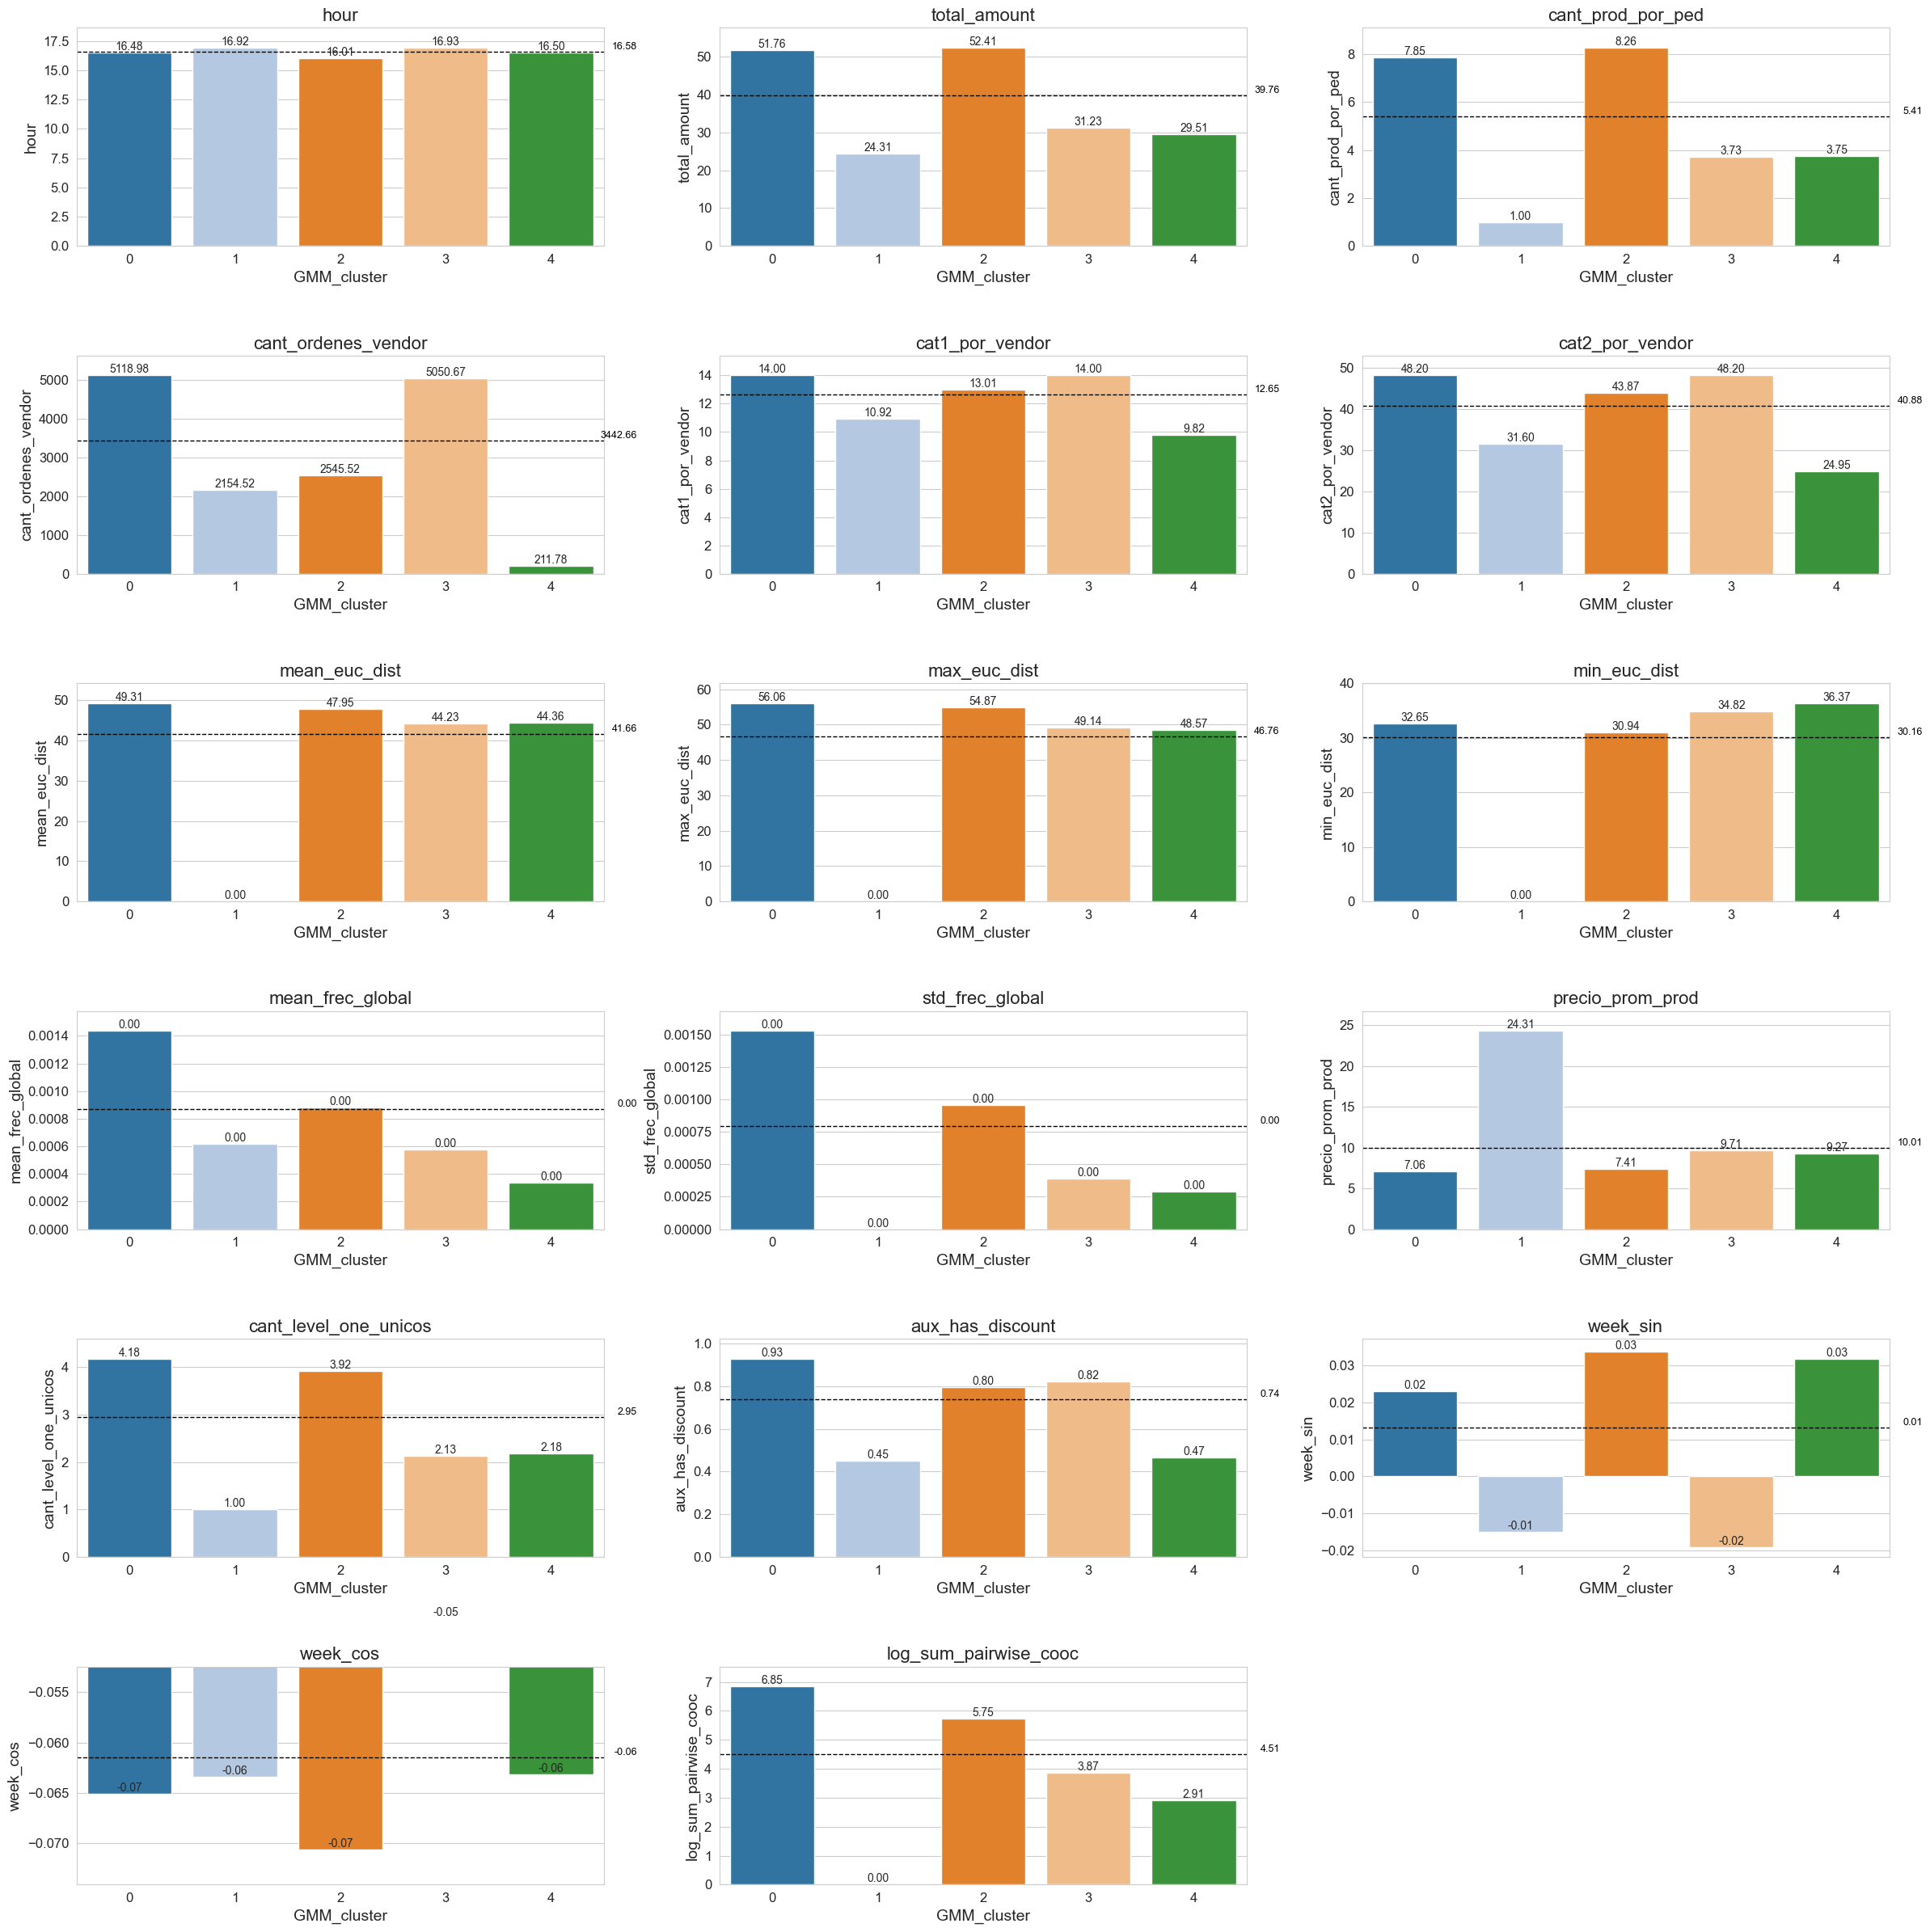

In [51]:
vars = medias.drop(columns = sem_cols + cat_cols).columns

bar_plots_N_var(vars)

## Conclusiones

Según la implementación de Gaussian Mixture con k = 5, se identificaron cinco grupos de órdenes de compra en supermercados con perfiles bien diferenciados, que reflejan tanto patrones de comportamiento como preferencias comerciales. Aquí va una descripción sintetizada basada en los resultados del documento:
- **Cluster 0 — Equilibradas y planificadas (≈18.6 %)** Órdenes con variedad moderada, productos de rotación media y presencia de múltiples categorías. Tienden a realizarse en tardes y noches de días laborales, con comportamiento consistente y planificado.

- **Cluster 1 — Funcionales y acotadas (≈21.8 %**)
Pedidos simples y centrados en pocas categorías con alta rotación. Baja presencia de descuentos. Comunes en horarios laborales diurnos. Responden a necesidades operativas o de reposición rápida.

- **Cluster 2 — Urgentes y monocategoría (≈10.7 %)**
Órdenes de un único producto, usualmente caro. Sin descuentos. Predominan en noches o momentos fuera de horario pico. Indican urgencia, impulsividad o compra puntual sin planificación previa.

- **Cluster 3 — Amplias y promocionales (≈34.7 %)**
Pedidos completos y de alto volumen, con diversidad de productos populares. Alta concentración de descuentos y frecuencia en horarios pico. Representan compras estratégicas y preparadas.

- **Cluster 4 — Selectivas y especializadas (≈14.2 %)**
Órdenes con enfoque en productos distintivos de categorías específicas. Se concentran en fines de semana y denotan intención de compra orientada a valor, calidad o selección deliberada.